# Анализ доходности рублевых облигаций Московской Биржи
<img src="http://toplogos.ru/images/logo-moskovskaya-birzha.png" width ="500" height=500 >
<table style="width:30%">
    <tr>
        <th>Выполнил:</th>
        <td>Зыльков П.А.</td>
    </tr>
    <tr>
        <th>Руководитель:</th>
        <td>Зуев А.В.</td>
    </tr>
</table>

## Импорт библиотек

In [247]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as sts
import chardet
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None
%matplotlib inline

## Импорт данных 

In [248]:
file = 'rates 12052021.csv'

with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
    
df = pd.read_csv(file, encoding=result['encoding'], sep=';', header=1)

## Выбранные поля
<b>SECID</b> - Код ценной бумаги<br> 
<b>NAME</b> - Полное наименование<br>
<b>FACEVALUE</b> - Номинальная стоимость<br>
<b>FACEUNIT</b> - Валюта номинала<br>
<b>DURATION</b> - Дюрация<br>
<b>IS_QUALIFIED_INVESTORS</b> - Для квалифицированных инвесторов<br>
<b>HIGH_RISK</b> - Высокий риск<br>
<b>COUPONFREQUENCY</b> - Периодичность выплаты купона в год<br> 
<b>COUPONDATE</b> - Дата следующего купона<br>
<b>COUPONPERCENT</b> - Ставка купона, %<br>
<b>COUPONVALUE</b> - Сумма купона, в валюте номинала<br>
<b>COUPONDAYSPASSED</b> - Дней прошло после выплаты купона<br>
<b>COUPONDAYSREMAIN</b> - Дней осталось до выплаты купона <br>
<b>COUPONLENGTH</b> - Купонный период<br>
<b>MATDATE</b> - Дата погашения<br>
<b>PRICE</b> - Цена покупки, % от номинала<br> 
<b>PRICE_RUB</b> - Цена покупки<br>


In [249]:
df_sliced = df[['SECID', 'NAME','IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'FACEVALUE', 'FACEUNIT', 'DURATION', 'COUPONFREQUENCY', 'COUPONDATE', 'MATDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED', 'COUPONDAYSREMAIN', 'COUPONLENGTH', 'PRICE', 'PRICE_RUB']]

<i>Возьмем только рублевые и низкорисковые облигации, предназанченые <b>не</b> только для квалифицированных инвесторов</i>

In [250]:
df_rub = df_sliced[(df_sliced['FACEUNIT']=='RUB') & (df_sliced['IS_QUALIFIED_INVESTORS']==0) & (df_sliced['SECID'] != 'RU000A0ZZ7R8') & (df_sliced['SECID'] != 'RU000A101HQ3') & (df_sliced['SECID'] != 'RU000A0JQ8V9') & (df_sliced['HIGH_RISK']==0)]

In [251]:
df_rub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1930 entries, 9 to 2219
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   1930 non-null   object 
 1   NAME                    1930 non-null   object 
 2   IS_QUALIFIED_INVESTORS  1930 non-null   int64  
 3   HIGH_RISK               1930 non-null   int64  
 4   FACEVALUE               1930 non-null   object 
 5   FACEUNIT                1930 non-null   object 
 6   DURATION                1389 non-null   float64
 7   COUPONFREQUENCY         1641 non-null   float64
 8   COUPONDATE              1927 non-null   object 
 9   MATDATE                 1923 non-null   object 
 10  COUPONPERCENT           1898 non-null   object 
 11  COUPONVALUE             1898 non-null   object 
 12  COUPONDAYSPASSED        1927 non-null   float64
 13  COUPONDAYSREMAIN        1927 non-null   float64
 14  COUPONLENGTH            1927 non-null   

## Подготовка данных

<i>Избавимся от неполных данных и приведем оставшиеся к валидному виду</i>

In [252]:
def convert(val):
    """
    Convert the string number value to a float
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','.')
    return float(new_val)

In [253]:
df_rub.dropna(subset=['COUPONPERCENT', 'COUPONFREQUENCY', 'MATDATE', 'COUPONVALUE', 'PRICE_RUB'], inplace=True)

df_rub['COUPONPERCENT'] = df_rub['COUPONPERCENT'].apply(convert)
df_rub['COUPONVALUE'] = df_rub['COUPONVALUE'].apply(convert)
df_rub['FACEVALUE'] = df_rub['FACEVALUE'].apply(convert)
df_rub['PRICE'] = df_rub['PRICE'].apply(convert)
df_rub['PRICE_RUB'] = df_rub['PRICE_RUB'].apply(convert)
df_rub['COUPONDATE'] =df_rub['COUPONDATE'].apply(pd.to_datetime)
df_rub['MATDATE'] = df_rub['MATDATE'].apply(pd.to_datetime)

## Кластеризация методом K-средних
<i>Признаки для кластеризации:<br>
    <ul>
        <li>Цена покупки</li>
        <li>Процент купонной доходности</li>
    </ul>

In [254]:
X = df_rub.iloc[:, [10, 16]].values

### Количество кластеров с помощью метода "локтя"

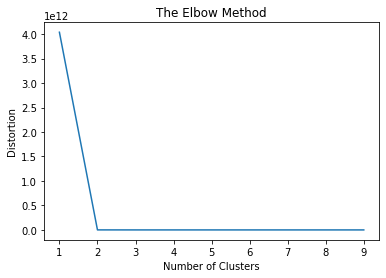

In [255]:
distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(X)
    distortion.append(model.inertia_) 
    
plt.plot(K, distortion)

plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion');

---
<i>Следуя графику возьмем количество кластеров равное 2</i>

In [256]:
model = KMeans(n_clusters=2, random_state=12345)
y_means = model.fit_predict(X)

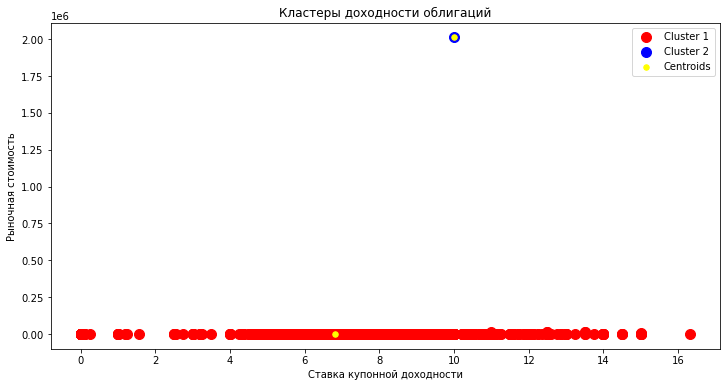

In [257]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(X[y_means == 0, 0], X[y_means == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_means == 1, 0], X[y_means == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=30, c='yellow', label='Centroids')

plt.title('Кластеры доходности облигаций')
plt.ylabel('Рыночная стоимость')
plt.xlabel('Cтавка купонной доходности')
plt.legend();

---
<i>На графике наглядно видно количетство выделенных кластеров рублевых облигаций (желтым выделены их центроиды):<br> 
- Cluster 1 - дешевые облигации (около 1000 руб.) с разнообразной купонной доходностью<br> 
- Cluster 2 - дорогие облигации, купонная доходность примерно в одном диапозоне значений, в данном случае она одна<br>
    
Можно сделать вывод, что ключевым признаком для кластеризации данных стала цена облигации</i>

## Дополнение данных и анализ

<i>Добавим НКД и количество оставшихся купонов по каждой облигации</i>

In [258]:
df_rub['NKD'] = df_rub['FACEVALUE'] * (df_rub['COUPONPERCENT'] / 100) / df_rub['COUPONFREQUENCY'] * df_rub['COUPONDAYSPASSED'] / df_rub['COUPONLENGTH'] 
df_rub['COUPONLEFT'] = abs(df_rub['MATDATE'] - df_rub['COUPONDATE']).dt.days // df_rub['COUPONLENGTH'] + 1

### Функция расчета годовой прибыли

In [259]:
def profit_count(price, buy_price, nkd, coupon_price, coupon_left):
    earnings = 0.87 * coupon_price * coupon_left - nkd + price
    #if buy_price >= price:
    #    earnings = (coupon_price * coupon_left) - (0.13 * coupon_price * coupon_left) + price
    #else:
    #    earnings = (coupon_price * coupon_left) - (0.13 * coupon_price * coupon_left) + price - 0.13 * (price - buy_price)
    profit = ((earnings - buy_price) * 100 / price) 
    return profit

<i>Рассчитаем годовой процент прибыли по каждой облигации</i>

In [260]:
df_rub['PROFIT'] = df_rub.apply(lambda row: profit_count(row['FACEVALUE'], row['PRICE_RUB'], row['NKD'], row['COUPONVALUE'], row['COUPONFREQUENCY']), axis=1)

In [261]:
df_rub.head(10)

,SECID,NAME,IS_QUALIFIED_INVESTORS,HIGH_RISK,FACEVALUE,FACEUNIT,DURATION,COUPONFREQUENCY,COUPONDATE,MATDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,PRICE,PRICE_RUB,NKD,COUPONLEFT,PROFIT
9,RU000A0JNYN1,Гор.Обл.Займ Москвы 48 в.,0,0,1000.0,RUB,379.0,2.0,2021-11-06,2022-11-06,6.00,29.92,152.0,30.0,182.0,100.1180,1026.1700,25.054945,3.0,0.083585
11,RU000A0JQ7Z2,"""Российские ЖД"" ОАО 19 обл.",0,0,1000.0,RUB,1020.0,2.0,2021-12-07,2024-08-07,7.85,39.14,121.0,61.0,182.0,103.1950,1057.9700,26.094780,6.0,-1.596118
13,RU000A0JQAL8,ДОМ.РФ (АО) обл. сер. А14,0,0,1000.0,RUB,677.0,2.0,2021-05-15,2023-05-15,6.75,33.47,178.0,3.0,181.0,105.4370,1087.2900,33.190608,5.0,-6.224281
14,RU000A0JQAM6,ДОМ.РФ (АО) обл. сер. А15,0,0,1000.0,RUB,2172.0,2.0,2021-09-15,2028-09-15,6.75,34.03,58.0,126.0,184.0,113.3870,1144.6000,10.638587,14.0,-9.602639
15,RU000A0JQRD9,"""Российские ЖД"" ОАО 23 обл.",0,0,1000.0,RUB,1171.0,2.0,2021-07-22,2025-01-16,7.85,39.14,111.0,71.0,182.0,103.7870,1061.7400,23.938187,8.0,-1.757459
16,RU000A0JQXG0,ДОМ.РФ (АО) обл. сер. А16,0,0,100.0,RUB,124.0,4.0,2021-06-15,2021-09-15,8.25,2.08,58.0,34.0,92.0,101.0875,102.3975,1.300272,2.0,3.540628
17,RU000A0JR4U9,Главная дорога АО об.сер. 03,0,0,1000.0,RUB,1315.0,1.0,2021-08-11,2028-10-30,4.00,39.89,184.0,180.0,364.0,97.8880,999.0400,20.219780,8.0,1.544452
18,RU000A0JR5F7,ДОМ.РФ (АО) обл. сер.А17,0,0,150.0,RUB,326.0,4.0,2021-07-15,2022-04-15,9.05,3.38,27.0,64.0,91.0,102.6520,154.9780,1.006937,4.0,3.851642
19,RU000A0JRDY3,ДОМ.РФ (АО) обл. сер.А18,0,0,700.0,RUB,18.0,4.0,2021-07-15,2023-07-15,5.25,9.16,27.0,64.0,91.0,100.9650,709.4750,2.725962,9.0,2.810834
20,RU000A0JRHF3,Акрон (ПАО) об. сер. 04,0,0,1000.0,RUB,6.0,2.0,2021-05-18,2021-05-18,6.50,32.41,176.0,6.0,182.0,100.0570,1031.9100,31.428571,1.0,-0.694517


## Графики

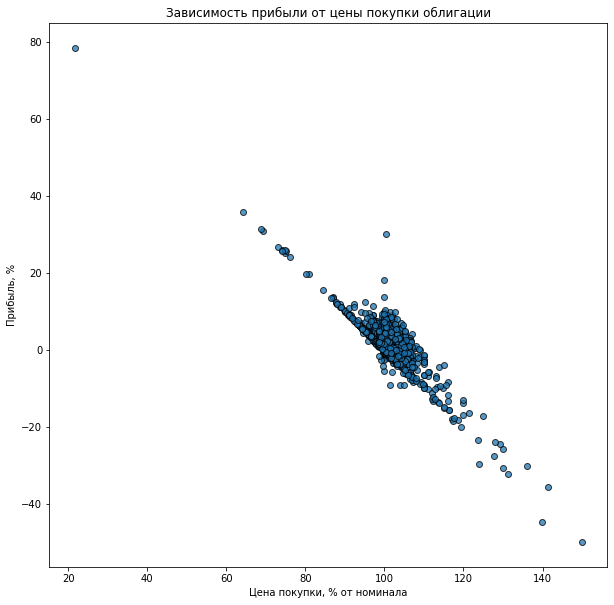

In [262]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(df_rub['PRICE'], df_rub['PROFIT'], edgecolor='black', alpha=0.75, linewidth=1)

plt.title('Зависимость прибыли от цены покупки облигации')
plt.xlabel('Цена покупки, % от номинала')
plt.ylabel('Прибыль, %')

plt.show()

---
<i>Смотря на график можно заметить очень интересный факт - чем <b>меньше</b> цена покупки облигации относительно её номинальной стоимости, тем <b>больше</b> доходность данной облигации и наоборот</i>

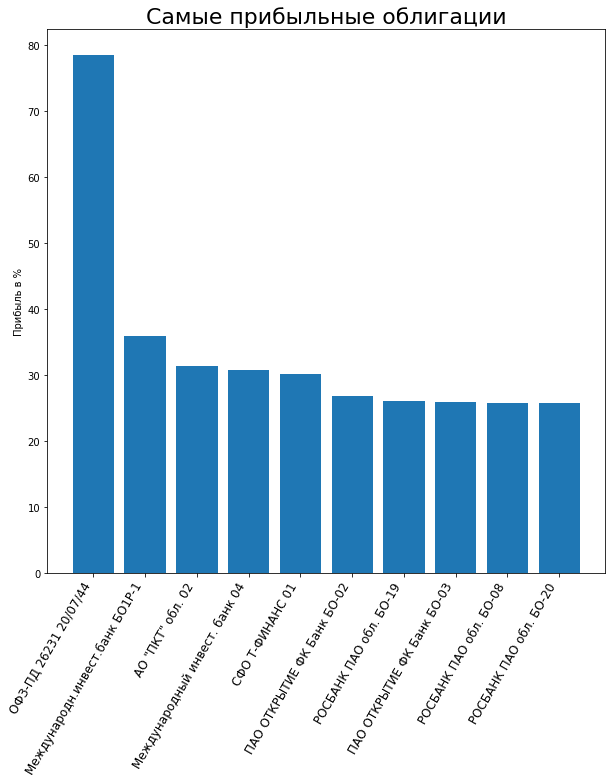

In [263]:
fig, ax = plt.subplots(figsize = (10, 10))
top_profit = df_rub.sort_values(by='PROFIT', ascending=False).head(10)
ax.bar(top_profit['NAME'], top_profit['PROFIT'])
ax.set_xticklabels(top_profit['NAME'], rotation=60, horizontalalignment='right', fontsize='12')

ax.set_title('Самые прибыльные облигации', fontsize=22)
ax.set_ylabel('Прибыль в %')

plt.show()

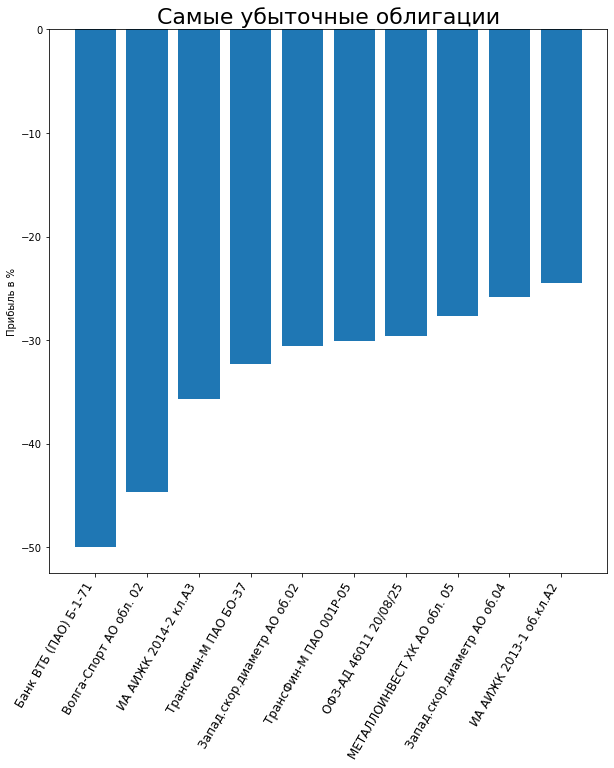

In [264]:
fig, ax = plt.subplots(figsize = (10, 10))
top_profit = df_rub.sort_values(by='PROFIT', ascending=True).head(10)
ax.bar(top_profit['NAME'], top_profit['PROFIT'])
ax.set_xticklabels(top_profit['NAME'], rotation=60, horizontalalignment='right', fontsize='12')

ax.set_title('Самые убыточные облигации', fontsize=22)
ax.set_ylabel('Прибыль в %')

plt.show()

## Самые прибыльные облигации

In [265]:
df_rub.sort_values(by='PROFIT', ascending=False).head(20)

,SECID,NAME,IS_QUALIFIED_INVESTORS,HIGH_RISK,FACEVALUE,FACEUNIT,DURATION,COUPONFREQUENCY,COUPONDATE,MATDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,PRICE,PRICE_RUB,NKD,COUPONLEFT,PROFIT
2187,SU26231RMFS9,ОФЗ-ПД 26231 20/07/44,0,0,1000.0,RUB,NaN,2.0,2021-08-18,2044-07-20,0.25,1.25,84.0,98.0,182.0,21.633,216.91,0.576923,47.0,78.468808
537,RU000A0JXT58,Международн.инвест.банк БО1P-1,0,0,1000.0,RUB,NaN,2.0,2021-06-09,2027-01-03,0.01,0.05,65.0,117.0,182.0,64.118,641.18,0.017857,12.0,35.888914
335,RU000A0JW5E3,"АО ""ПКТ"" обл. 02",0,0,1000.0,RUB,1730.0,2.0,2021-08-13,2026-06-02,0.01,0.05,89.0,93.0,182.0,68.682,686.82,0.024451,10.0,31.324255
167,RU000A0JUG98,Международный инвест. банк 04,0,0,1000.0,RUB,1638.0,2.0,2021-05-13,2025-06-11,0.01,0.05,181.0,1.0,182.0,69.241,692.41,0.049725,9.0,30.762727
1986,RU000A102L20,СФО Т-ФИНАНС 01,0,0,1000.0,RUB,NaN,4.0,2022-11-01,2025-07-01,10.00,99.73,120.0,244.0,364.0,100.489,1037.77,8.241758,3.0,30.104864
120,RU000A0JU0N7,ПАО ОТКРЫТИЕ ФК Банк БО-02,0,0,1000.0,RUB,1595.0,2.0,2021-09-24,2025-09-24,0.01,0.05,49.0,135.0,184.0,73.181,731.82,0.013315,8.0,26.825368
308,RU000A0JVWA5,РОСБАНК ПАО обл. БО-19,0,0,1000.0,RUB,NaN,2.0,2021-10-30,2025-10-30,1.00,5.01,12.0,171.0,183.0,74.813,748.46,0.327869,8.0,25.992953
45,RU000A0JRZ74,ПАО ОТКРЫТИЕ ФК Банк БО-03,0,0,1000.0,RUB,1525.0,2.0,2021-07-16,2025-07-16,0.01,0.05,116.0,65.0,181.0,74.031,740.34,0.032044,9.0,25.971496
301,RU000A0JVUY9,РОСБАНК ПАО обл. БО-08,0,0,1000.0,RUB,1585.0,2.0,2021-10-20,2025-10-20,1.00,5.01,22.0,161.0,183.0,75.013,750.73,0.601093,8.0,25.738631
356,RU000A0JWGS8,РОСБАНК ПАО обл. БО-20,0,0,1000.0,RUB,1772.0,2.0,2021-05-18,2026-05-18,1.00,4.96,175.0,6.0,181.0,74.188,746.67,4.834254,11.0,25.712615
